In [ ]:
from google.colab  import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

#Modelling

model menggunakan algoritma LOGISTIC REGRESION.
 data dikelompokkan menjadi bagian2 kecil, contoh(age 0-40 dijadikan satu, 41-50 dijadikan satu)
lalu mengambil WOE pada masing2 kelompok

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# ============================================
#              LOAD DATASET
# ============================================
df = pd.read_csv("/content/drive/MyDrive/risikostroke/healthcare-dataset-stroke-data.csv")

df = df.drop(columns=["id"])
df["bmi"] = df["bmi"].fillna(df["bmi"].median())

# Pastikan kategori
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for c in cat_cols:
    df[c] = df[c].astype(str)

y = df["stroke"]
X = df.drop(columns=["stroke"])


# ============================================
#         BINNING DEFINITIONS
# ============================================

age_bins = [0, 40, 55, 70, 200]
age_labels = ["0-40", "40-55", "55-70", "70+"]

glucose_bins = [0, 100, 140, 200, 500]
glucose_labels = ["<100", "100-140", "140-200", ">200"]

bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ["Underweight", "Normal", "Overweight", "Obese"]

# ============================================
#       APPLY BINNING
# ============================================
Xb = pd.DataFrame(index=X.index)
Xb["age_bin"] = pd.cut(X["age"], bins=age_bins, labels=age_labels, include_lowest=True)
Xb["glucose_bin"] = pd.cut(X["avg_glucose_level"], bins=glucose_bins, labels=glucose_labels, include_lowest=True)
Xb["bmi_bin"] = pd.cut(X["bmi"], bins=bmi_bins, labels=bmi_labels, include_lowest=True)

for col in cat_cols:
    Xb[col] = X[col]

bin_cols = list(Xb.columns)


# ============================================
#  COMPUTE WOE FOR ALL CATEGORICAL FEATURES
# ============================================

good = (y == 0).sum()
bad = (y == 1).sum()

woe_maps = {}

for col in bin_cols:
    tmp = pd.DataFrame({"bin": Xb[col], "y": y})
    stats = tmp.groupby("bin")["y"].agg(["count", "sum"])
    stats.rename(columns={"sum": "bad"}, inplace=True)
    stats["good"] = stats["count"] - stats["bad"]

    n_cats = len(stats)

    # smoothing
    stats["good_rate"] = (stats["good"] + 0.5) / (good + 0.5 * n_cats)
    stats["bad_rate"]  = (stats["bad"]  + 0.5) / (bad  + 0.5 * n_cats)

    stats["woe"] = np.log(stats["bad_rate"] / stats["good_rate"])

    woe_maps[col] = stats["woe"].to_dict()


# ============================================
#           BUILD WOE MATRIX
# ============================================
X_woe = pd.DataFrame(index=X.index)

# WOE columns
for col in bin_cols:
    X_woe[col + "_woe"] = Xb[col].map(woe_maps[col])

# Numeric features (keep raw)
X_woe["hypertension"] = X["hypertension"]
X_woe["heart_disease"] = X["heart_disease"]

# Final cleanup

for col in X_woe.columns:
    X_woe[col] = pd.to_numeric(X_woe[col], errors="coerce")

# BARU boleh fillna + astype
X_woe = X_woe.fillna(0).astype(float)



# ============================================
#       TRAIN LOGISTIC REGRESSION
# ============================================
model = LogisticRegression(max_iter=5000, class_weight="balanced")
model.fit(X_woe, y)

coef_df = pd.DataFrame({
    "feature": X_woe.columns,
    "coefficient": model.coef_[0]
}).sort_values("coefficient", ascending=False)

print("\n==============================")
print(" FINAL COEFFICIENTS (ALL FEATURES)")
print("==============================")
print(coef_df)

print("\nINTERCEPT:", model.intercept_[0])


# ============================================
#             PRINT WOE TABLES
# ============================================
print("\n==============================")
print("  WOE TABLES (PER FEATURE)")
print("==============================")

for col in bin_cols:
    print(f"\n--- {col.upper()} ---")
    df_woe = pd.DataFrame([
        {"bin": k, "woe": v}
        for k, v in woe_maps[col].items()
    ])
    print(df_woe)


# ============================================
#  PREDICTION FUNCTION (USED IN YOUR FLASK APP)
# ============================================

def apply_bin(val, bins, labels):
    return pd.cut(pd.Series([val]), bins=bins, labels=labels, include_lowest=True).iloc[0]

def predict_risk(sample):
    sb = {}

    # binning
    sb["age_bin"] = apply_bin(sample["age"], age_bins, age_labels)
    sb["glucose_bin"] = apply_bin(sample["glucose"], glucose_bins, glucose_labels)
    sb["bmi_bin"] = apply_bin(sample["bmi"], bmi_bins, bmi_labels)

    # copy categorical original
    sb["gender"] = sample["gender"]
    sb["ever_married"] = sample["ever_married"]
    sb["work_type"] = sample["work_type"]
    sb["Residence_type"] = sample["Residence_type"]
    sb["smoking_status"] = sample["smoking_status"]

    # map WOE
    sw = {}
    for col in bin_cols:
        sw[col + "_woe"] = woe_maps[col].get(sb[col], 0)

    # numeric
    sw["hypertension"] = sample["hypertension"]
    sw["heart_disease"] = sample["heart_disease"]

    Xs = pd.DataFrame([sw])
    prob = model.predict_proba(Xs)[0, 1]
    return prob


# ============================================
# 9) TEST
# ============================================
test = {
    "age": 61,
    "glucose": 180,
    "bmi": 27,
    "gender": "Male",
    "ever_married": "Yes",
    "work_type": "Private",
    "Residence_type": "Urban",
    "smoking_status": "formerly smoked",
    "hypertension": 1,
    "heart_disease": 1
}

print("\n==============================")
print(" TEST PREDICTION")
print("==============================")
print("Risk =", predict_risk(test))



 FINAL COEFFICIENTS (ALL FEATURES)
              feature  coefficient
0         age_bin_woe     0.932249
2         bmi_bin_woe     0.678346
8        hypertension     0.546766
6  Residence_type_woe     0.447152
9       heart_disease     0.446268
1     glucose_bin_woe     0.359952
7  smoking_status_woe     0.287368
4    ever_married_woe     0.008489
5       work_type_woe    -0.213577
3          gender_woe    -1.356776

INTERCEPT: -0.18901998817349125

  WOE TABLES (PER FEATURE)

--- AGE_BIN ---
     bin       woe
0   0-40 -2.608643
1  40-55 -0.624399
2  55-70  0.569374
3    70+  1.452558

--- GLUCOSE_BIN ---
       bin       woe
0     <100 -0.325935
1  100-140 -0.256714
2  140-200  0.728938
3     >200  1.061982

--- BMI_BIN ---
           bin       woe
0  Underweight -2.484215
1       Normal -0.519536
2   Overweight  0.403013
3        Obese  0.039349

--- GENDER ---
      bin       woe
0  Female -0.038153
1    Male  0.047954
2   Other  1.867237

--- EVER_MARRIED ---
   bin       woe
0  

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/risikostroke/healthcare-dataset-stroke-data.csv")

def compute_woe_binary(df, feature, target="stroke"):
    # Hitung total good & bad
    good_total = (df[target] == 0).sum()
    bad_total = (df[target] == 1).sum()

    woe = {}

    for val in [0, 1]:
        good = ((df[feature] == val) & (df[target] == 0)).sum()
        bad  = ((df[feature] == val) & (df[target] == 1)).sum()

        # Laplace smoothing
        good_rate = (good + 0.5) / (good_total + 1)
        bad_rate  = (bad + 0.5) / (bad_total + 1)

        woe[val] = np.log(bad_rate / good_rate)

    return woe

woe_hyp = compute_woe_binary(df, "hypertension")
woe_hd  = compute_woe_binary(df, "heart_disease")

print("WOE Hypertension:", woe_hyp)
print("WOE Heart Disease:", woe_hd)


WOE Hypertension: {0: np.float64(-0.21608308534363982), 1: np.float64(1.0953638583036969)}
WOE Heart Disease: {0: np.float64(-0.1623678345990987), 1: np.float64(1.392570918553818)}


#WOE TIAP KELOMPOK

WOE dijadikan sebagai variabel X, pada fungsi z = sigma(Wi*Xi) + b

coef atau KOEFISIEN FITUR (pada blok sebelumnyaa) dijadikan variabel W pada fungsi z = sigma(WI*Xi)+b

#eval dan cari roc

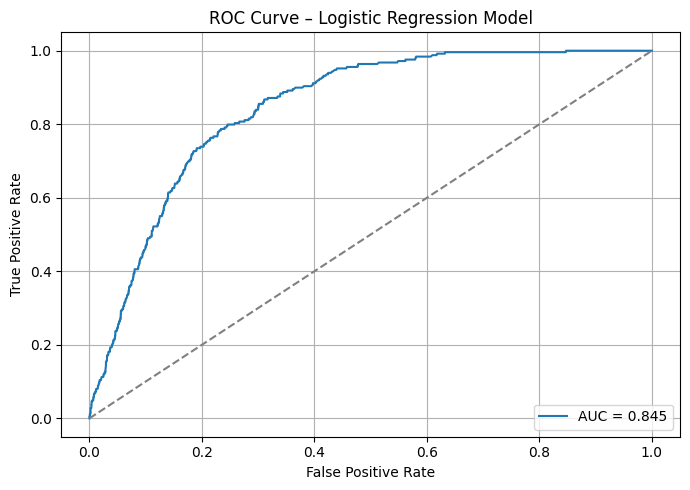


 OPTIMAL CUTOFF (YOUDEN INDEX)
Threshold terbaik: 0.4545


In [ ]:
# ============================================
#             EVALUASI MODEL: ROC CURVE
# ============================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# prediksi probabilitas semua data (bukan cuma test)
y_pred_prob = model.predict_proba(X_woe)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# cari threshold optimal (Youden Index)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

print("\n==============================")
print(" OPTIMAL CUTOFF (YOUDEN INDEX)")
print("==============================")
print(f"Threshold terbaik: {optimal_threshold:.4f}")


#KLASIFIKASI 3 LEVEL (LOW, MODERATE, HIGH)

cek apa yang terjadi pada youden index : 0.4545

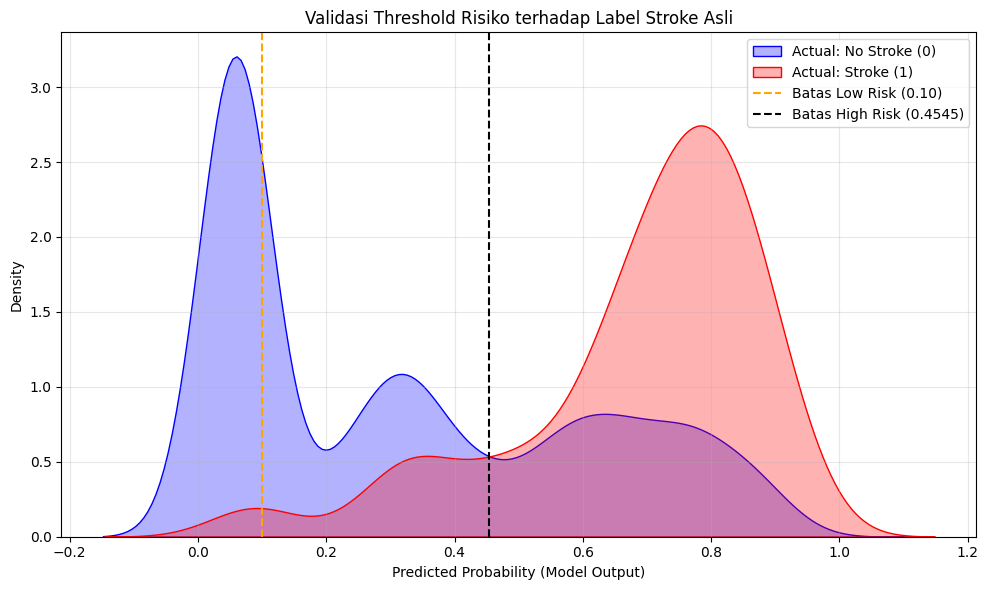

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumsi:
# y = label asli (stroke: 0 = tidak, 1 = ya)
# y_pred_prob = probabilitas hasil model
# threshold yang diuji: 0.093 (low), 0.4545 (high)

plt.figure(figsize=(10, 6))

# Distribusi probabilitas untuk yang tidak stroke (y==0)
sns.kdeplot(
    y_pred_prob[y == 0],
    color='blue',
    fill=True,
    label='Actual: No Stroke (0)',
    alpha=0.3
)

# Distribusi probabilitas untuk yang stroke (y==1)
sns.kdeplot(
    y_pred_prob[y == 1],
    color='red',
    fill=True,
    label='Actual: Stroke (1)',
    alpha=0.3
)

# Tambahkan garis cutoff threshold
plt.axvline(0.10, color='orange', linestyle='--', label='Batas Low Risk (0.10)')
plt.axvline(0.4545, color='black', linestyle='--', label='Batas High Risk (0.4545)')

plt.title('Validasi Threshold Risiko terhadap Label Stroke Asli')
plt.xlabel('Predicted Probability (Model Output)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
